# Superset Dataset Export

In [2]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type
from mgds.data_aggregation import io_utils as io
from mgds.data_aggregation import entity
from mgds.data_aggregation import api as mgds_api
from mgds.data_aggregation.export_lib import sql_export
from py_utils import set_utils, collection_utils, assertion_utils
pd.set_option('display.max_info_rows', 50000000)

2016-12-08 17:59:17,580:INFO:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [3]:
d_id = mgds_api.get_entity_mapping(entity.CELL_LINE)
d_id.head()

TAXONOMY                          COMMON                                 \
SOURCE                           ccle_v1                                  
DATA_TYPE                  cellline-meta               gene-copy-number   
MGDS_ID                                                                   
1321N1     1321N1_CENTRAL_NERVOUS_SYSTEM  1321N1_CENTRAL_NERVOUS_SYSTEM   
143B                           143B_BONE                      143B_BONE   
184A1                               None                           None   
184B5                               None                           None   
2004                                None                           None   

TAXONOMY                                                                  \
SOURCE                                                            ctd_v2   
DATA_TYPE gene-exome-seq                gene-expression drug-sensitivity   
MGDS_ID                                                                    
1321N1              None  1321N1_CENTRAL_NERVOUS_SYSTEM             None   
143B                None                      143B_BONE             None   
184A1               None                           None             None   
184B5               None                           None             None   
2004                None                           None             2004   

TAXONOMY                                                                  \
SOURCE          gdsc_v2                                                    
DATA_TYPE cellline-meta drug-sensitivity gene-copy-number gene-exome-seq   
MGDS_ID                                                                    
1321N1             None             None             None           None   
143B               None             None             None           None   
184A1              None             None             None           None   
184B5              None             None             None           None   
2004               None             None             None           None   

TAXONOMY                        ...                                        \
SOURCE                          ...           ncidream_v1                   
DATA_TYPE gene-expression       ...        gene-exome-seq gene-expression   
MGDS_ID                         ...                                         
1321N1               None       ...                  None            None   
143B                 None       ...                  None            None   
184A1                None       ...                 184A1            None   
184B5                None       ...                 184B5           184B5   
2004                 None       ...                  None            None   

TAXONOMY                                       COSMIC                   \
SOURCE                                        gdsc_v2                    
DATA_TYPE gene-methylation gene-rna-seq cellline-meta drug-sensitivity   
MGDS_ID                                                                  
1321N1                None         None          None             None   
143B                  None         None          None             None   
184A1                 None        184A1          None             None   
184B5                 None        184B5          None             None   
2004                  None         None          None             None   

TAXONOMY                                                               CTD  
SOURCE                                                              ctd_v2  
DATA_TYPE gene-copy-number gene-exome-seq gene-expression drug-sensitivity  
MGDS_ID                                                                     
1321N1                None           None            None             None  
143B                  None           None            None             None  
184A1                 None           None            None             None  
184B5                 None           None            N

In [4]:
d_ps = mgds_api.get_entity_mapping(entity.PRIMARY_SITE)
d_ps.head()

,SOURCE,ccle_v1,gdsc_v2,nci60_v2,ncidream_v1
CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,,,,
1321N1,CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM,None,None,None
143B,BONE,BONE,None,None,None
184A1,BREAST,None,None,None,BREAST
184B5,BREAST,None,None,None,BREAST
201T,LUNG,None,LUNG,None,None


In [5]:
d_rx = mgds_api.get_entity_mapping(entity.DRUG)
d_rx.head()

TAXONOMY                                 BROAD COMMON          \
SOURCE                                  ctd_v2 ctd_v2 gdsc_v2   
DRUG_NAME:MGDS                                                  
010200                                    None   None    None   
1011METHYLENEDIOXY20RSCAMPTOTHECIN        None   None    None   
1011METHYLENEDIOXYCAMPTOTHECIN            None   None    None   
1024DICHLOROPHENYL3METHYLFLAVIN           None   None    None   
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM   None   None    None   

TAXONOMY                                                                               \
SOURCE                                                                       nci60_v2   
DRUG_NAME:MGDS                                                                          
010200                                                                         010200   
1011METHYLENEDIOXY20RSCAMPTOTHECIN           10,11-methylenedioxy-20(rs)-camptothecin   
1011METHYLENEDIOXYCAMPTOTHECIN                       10,11-methylenedioxycamptothecin   
1024DICHLOROPHENYL3METHYLFLAVIN              10-(2',4'-dichlorophenyl)-3-methylflavin   
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM  10-(6'-ubiquinolyl)decyltriphenylphosphonium   

TAXONOMY                                             COSMIC    CTD      NSC  \
SOURCE                                  ncidream_v1 gdsc_v2 ctd_v2 nci60_v2   
DRUG_NAME:MGDS                                                                
010200                                         None    None   None   529108   
1011METHYLENEDIOXY20RSCAMPTOTHECIN             None    None   None   606174   
1011METHYLENEDIOXYCAMPTOTHECIN                 None    None   None   634724   
1024DICHLOROPHENYL3METHYLFLAVIN                None    None   None   625537   
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM        None    None   None   745025   

TAXONOMY                                     PUBCHEM  
SOURCE                                      nci60_v2  
DRUG_NAME:MGDS                                        
010200                                        482905  
1011METHYLENEDIOXY20RSCAMPTOTHECIN            580568  
1011METHYLENEDIOXYCAMPTOTHECIN                497235  
1024DICHLOROPHENYL3METHYLFLAVIN               492471  
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM  9.11476e+07

In [6]:
# d_rx[d_rx['COMMON']['ncidream_v1'].notnull()]

In [7]:
taxonomy = 'COMMON'
src_typs = d_rx[taxonomy].columns.values
srcs = np.unique(d_rx[taxonomy].columns.get_level_values('SOURCE'))
mappings={entity.CELL_LINE: d_id, entity.PRIMARY_SITE: d_ps, entity.DRUG: d_rx}
srcs

array(['ctd_v2', 'gdsc_v2', 'nci60_v2', 'ncidream_v1'], dtype=object)

In [64]:
d_drug = mgds_api.get_drug_sensitivity_data(srcs, mappings=mappings)
d_drug['EXPERIMENT_ID'] = d_drug['EXPERIMENT_ID'].astype(str)
assert np.all(d_drug['DRUG_NAME:MGDS'].notnull())
d_drug = d_drug[d_drug['CELL_LINE_ID:MGDS'].notnull()]

2016-12-09 09:01:11,651:WARNING:mgds.data_aggregation.api: Genomic data for source "ctd_v2" and data type "drug-sensitivity" has a cell line mapping but does not have a primary site mapping (so all primary site fields will be null)


In [65]:
d_drug.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488660 entries, 0 to 1140
Data columns (total 33 columns):
ACTION                 433297 non-null object
AUC                    600411 non-null float64
CELL_LINE_ID           1488660 non-null object
CELL_LINE_ID:COSMIC    205148 non-null object
CELL_LINE_ID:CTD       395263 non-null float64
CELL_LINE_ID:MGDS      1488660 non-null object
DRUG_ID:BROAD          395263 non-null object
DRUG_ID:COSMIC         205148 non-null float64
DRUG_ID:CTD            395263 non-null float64
DRUG_ID:NSC            887108 non-null float64
DRUG_ID:PUBCHEM        818965 non-null float64
DRUG_NAME              1488660 non-null object
DRUG_NAME:MGDS         1488660 non-null object
DRUG_NAME:SOURCE       1488660 non-null object
EXPERIMENT_ID          1488660 non-null object
FDA_STATUS             389856 non-null object
GI50_ZSCORE            887108 non-null float64
IC50_RESULTS_ID        205148 non-null object
LN_GI50                888249 non-null float64
LN

In [10]:
d_drug[d_drug['AUC'].notnull()]['SOURCE'].unique()

array(['ctd_v2', 'gdsc_v2'], dtype=object)

In [11]:
d_drug.groupby('DRUG_NAME:MGDS')['SOURCE'].nunique().value_counts()

1    4705
2     108
3      35
4       2
Name: SOURCE, dtype: int64

In [12]:
# d_drug[d_drug['CELL_LINE_ID:MGDS'].isnull()].head()

In [13]:
# d_drug.hist('LN_GI50', by='SOURCE', figsize=(12,6), bins=50)

In [52]:
d_drug['DRUG_NAME:MGDS'].nunique()

4850

In [66]:
d_drug.head()

,ACTION,AUC,CELL_LINE_ID,CELL_LINE_ID:COSMIC,CELL_LINE_ID:CTD,CELL_LINE_ID:MGDS,DRUG_ID:BROAD,DRUG_ID:COSMIC,DRUG_ID:CTD,DRUG_ID:NSC,...,PRIMARY_SITE:MGDS,PRIMARY_SITE:SOURCE,REPLICATE_COUNT,RMSE,SMILES,SOURCE,STATUS,SYNONYMS,TARGET,TARGET_PATHWAY
0,NaN,14.782,CAS1,NaN,130.0,CAS1,BRD-K46556387,NaN,1788.0,NaN,...,None,None,NaN,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,ctd_v2,probe,NaN,NaN,NaN
1,NaN,13.327,CAS1,NaN,130.0,CAS1,BRD-K86574132,NaN,3588.0,NaN,...,None,None,NaN,NaN,CC(C)N1C(=O)S\C(=C\c2ccc(Sc3nc4ccccc4[nH]3)o2)...,ctd_v2,probe,NaN,NaN,NaN
2,NaN,16.082,CAS1,NaN,130.0,CAS1,BRD-K35716340,NaN,12877.0,NaN,...,None,None,NaN,NaN,C(Cn1c2ccccc2c2ccccc12)c1nc2ccccc2[nH]1,ctd_v2,probe,NaN,NaN,NaN
3,NaN,13.743,CAS1,NaN,130.0,CAS1,BRD-K89329876,NaN,19153.0,NaN,...,None,None,NaN,NaN,CC(C)(C)c1ccc2cc(C#N)c(cc2c1)C#N,ctd_v2,probe,NaN,NaN,NaN
4,NaN,13.390,CAS1,NaN,130.0,CAS1,BRD-K45401373,NaN,23256.0,NaN,...,None,None,NaN,NaN,CC(=C)[C@@H]1CC[C@@]2(CC[C@]3(C)[C@H](CC[C@@H]...,ctd_v2,probe,NaN,NaN,NaN


In [125]:
d_drug_exp = d_drug.copy()

c_val = ['LN_GI50', 'LN_IC50', 'LOG2_EC50', 'AUC', 'GI50_ZSCORE']
c_grp = ['CELL_LINE_ID:MGDS', 'SOURCE', 'DRUG_NAME:MGDS']
c_meta = [
    'PRIMARY_SITE:MGDS', 'DRUG_NAME:SOURCE', 'FDA_STATUS', 
    'TARGET', 'TARGET_PATHWAY', 'EXPERIMENT_ID', 'SOURCE_N'
]

# Add number of unique sources per drug (convenient for filtering later on)
d_source_ct = d_drug_exp.groupby('DRUG_NAME:MGDS')['SOURCE'].nunique().rename('SOURCE_N').reset_index()
n_before = len(d_drug_exp)
d_drug_exp = pd.merge(d_drug_exp, d_source_ct, on='DRUG_NAME:MGDS', how='inner')
assert n_before == len(d_drug_exp)
assert np.all(d_drug_exp['SOURCE_N'].notnull())
del d_source_ct

# Remove unnecessary meta data fields by selecting only those known to be useful
d_drug_exp = d_drug_exp[c_val + c_grp + c_meta]

# Compute the mean measurement value for each cell line + drug + source combination with
# measurements in columns since aggregation this way is usually faster (as opposed to
# melting the measurements into rows first)
d_stat = d_drug_exp.groupby(c_grp)[c_val].mean().reset_index()

# Now compute the mean and standard deviation of the mean measurement values per source
d_stat = d_stat.groupby(['SOURCE'])[c_val].agg({'VMEAN': 'mean', 'VSTD': 'std'})

# Melt measurements into rows 
c_idx = list(d_drug_exp.columns.difference(c_val))
d_drug_exp = d_drug_exp.set_index(c_idx)
d_drug_exp.columns.name = 'MEASURE_UNIT'
d_drug_exp = d_drug_exp.stack().rename('MEASURE_VALUE').reset_index()

# Compute z-scores for each measurement where the mean and std used to compute these
# scores is not derived from individual experimental replicates but rather the means
# of those replicates for a particular source (i.e. the scoring is across cell lines and drugs)
def get_zscores(g):
    measure_unit = g['MEASURE_UNIT'].iloc[0]
    source = g['SOURCE'].iloc[0]
    
    # Find previously calculated mean and std for this drug and source
    stats = d_stat.loc[source]
    v_mean, v_std = stats['VMEAN'][measure_unit], stats['VSTD'][measure_unit]

    # Compute z scores for original measurements
    if source == src.NCI60_v2 and measure_unit == 'GI50_ZSCORE':
        g['MEASURE_VALUE_Z'] = g['MEASURE_VALUE']
    else:
        g['MEASURE_VALUE_Z'] = (g['MEASURE_VALUE'] - v_mean) / v_std
    return g
d_drug_exp = d_drug_exp.groupby(['SOURCE', 'MEASURE_UNIT'], group_keys=False).apply(get_zscores)
del d_stat

# Now that a z-score has been assigned for each measurement value (note that we still have individual records
# for each replicate, not just one per cell line + drug + source), compute summary information that best 
# describes the outcome of ALL experimental replicates for a single drug + cell line + source
agg_fn = {
    'MEASURE_VALUE': {'MEASURE_N': 'count', 'MEASURE_VALUE_MEAN': 'mean', 'MEASURE_VALUE_STD': 'std'},
    'MEASURE_VALUE_Z': {'MEASURE_VALUE_Z_MEAN': 'mean', 'MEASURE_VALUE_Z_STD': 'std'}
}
c_grp += ['MEASURE_UNIT']
d_stat = d_drug_exp.groupby(c_grp).agg(agg_fn)
d_stat.columns = d_stat.columns.droplevel(0)
d_stat = d_stat.reset_index()

# Join the summary information calculated above to the per-replicate dataset
n_before = len(d_drug_exp)
d_drug_exp = pd.merge(d_drug_exp, d_stat, on=c_grp, how='inner')

# Fill in missing std values with zeros (MEASURE_N can be used 
# to differentiate between no variance and one replicate)
for c in ['MEASURE_VALUE_STD', 'MEASURE_VALUE_Z_STD']:
    d_drug_exp[c] = d_drug_exp[c].fillna(0.)
assert n_before == len(d_drug_exp)
assert np.all(d_drug_exp.filter(regex='^MEASURE').notnull())
del d_stat

assertion_utils.assert_object_types(d_drug_exp)
d_drug_exp.head()

,CELL_LINE_ID:MGDS,DRUG_NAME:MGDS,DRUG_NAME:SOURCE,EXPERIMENT_ID,FDA_STATUS,PRIMARY_SITE:MGDS,SOURCE,SOURCE_N,TARGET,TARGET_PATHWAY,MEASURE_UNIT,MEASURE_VALUE,MEASURE_VALUE_Z,MEASURE_VALUE_STD,MEASURE_VALUE_MEAN,MEASURE_N,MEASURE_VALUE_Z_MEAN,MEASURE_VALUE_Z_STD
0,CAS1,CIL55,CIL55,1,NaN,NaN,ctd_v2,1,NaN,NaN,LOG2_EC50,3.170,0.282306,0.0,3.170,1,0.282306,0.0
1,CAS1,CIL55,CIL55,1,NaN,NaN,ctd_v2,1,NaN,NaN,AUC,14.782,0.770608,0.0,14.782,1,0.770608,0.0
2,KPL1,CIL55,CIL55,2,NaN,NaN,ctd_v2,1,NaN,NaN,LOG2_EC50,-9.110,-1.257159,0.0,-9.110,1,-1.257159,0.0
3,KPL1,CIL55,CIL55,2,NaN,NaN,ctd_v2,1,NaN,NaN,AUC,15.680,1.113574,0.0,15.680,1,1.113574,0.0
4,MKN1,CIL55,CIL55,3,NaN,NaN,ctd_v2,1,NaN,NaN,LOG2_EC50,-4.486,-0.677477,0.0,-4.486,1,-0.677477,0.0


In [126]:
#d_drug_exp[d_drug_exp['MEASURE_N'] > 5].head(10)

In [127]:
d_drug_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2976179 entries, 0 to 2976178
Data columns (total 18 columns):
CELL_LINE_ID:MGDS       2976179 non-null object
DRUG_NAME:MGDS          2976179 non-null object
DRUG_NAME:SOURCE        2976179 non-null object
EXPERIMENT_ID           2976179 non-null object
FDA_STATUS              779712 non-null object
PRIMARY_SITE:MGDS       2121671 non-null object
SOURCE                  2976179 non-null object
SOURCE_N                2976179 non-null int64
TARGET                  408442 non-null object
TARGET_PATHWAY          411437 non-null object
MEASURE_UNIT            2976179 non-null object
MEASURE_VALUE           2976179 non-null float64
MEASURE_VALUE_Z         2976179 non-null float64
MEASURE_VALUE_STD       2976179 non-null float64
MEASURE_VALUE_MEAN      2976179 non-null float64
MEASURE_N               2976179 non-null int64
MEASURE_VALUE_Z_MEAN    2976179 non-null float64
MEASURE_VALUE_Z_STD     2976179 non-null float64
dtypes: float64(6), in

In [128]:
# Finally, "summarize" the per-replicate data by choosing an arbitrary record for any cell line + drug + source.
# Both this summary and the per-replicate data may be useful in the future
d_drug_summary = d_drug_exp.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS', 'SOURCE', 'MEASURE_UNIT']).head(1)
d_drug_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650655 entries, 0 to 2976178
Data columns (total 18 columns):
CELL_LINE_ID:MGDS       1650655 non-null object
DRUG_NAME:MGDS          1650655 non-null object
DRUG_NAME:SOURCE        1650655 non-null object
EXPERIMENT_ID           1650655 non-null object
FDA_STATUS              19998 non-null object
PRIMARY_SITE:MGDS       860335 non-null object
SOURCE                  1650655 non-null object
SOURCE_N                1650655 non-null int64
TARGET                  408442 non-null object
TARGET_PATHWAY          411437 non-null object
MEASURE_UNIT            1650655 non-null object
MEASURE_VALUE           1650655 non-null float64
MEASURE_VALUE_Z         1650655 non-null float64
MEASURE_VALUE_STD       1650655 non-null float64
MEASURE_VALUE_MEAN      1650655 non-null float64
MEASURE_N               1650655 non-null int64
MEASURE_VALUE_Z_MEAN    1650655 non-null float64
MEASURE_VALUE_Z_STD     1650655 non-null float64
dtypes: float64(6), int6

In [111]:
d_drug_summary.groupby(['SOURCE', 'MEASURE_UNIT'])['MEASURE_VALUE_Z'].describe().unstack()

count          mean       std       min  \
SOURCE      MEASURE_UNIT                                               
ctd_v2      AUC           387130.0  8.528910e-04  1.001412 -4.848580   
            LOG2_EC50     387130.0 -5.420644e-04  1.006496 -2.622368   
gdsc_v2     AUC           205148.0  4.832998e-14  1.000000 -4.241602   
            LN_IC50       205148.0  7.933219e-15  1.000000 -4.368453   
nci60_v2    GI50_ZSCORE   232479.0 -1.600615e-15  1.000000 -7.710885   
            LN_GI50       232479.0  6.937497e-03  1.014400 -5.246357   
ncidream_v1 LN_GI50         1141.0 -1.818392e-15  1.000000 -2.994436   

                               25%       50%       75%       max  
SOURCE      MEASURE_UNIT                                          
ctd_v2      AUC          -0.441614  0.259214  0.695369  2.763479  
            LOG2_EC50    -0.348147  0.130992  0.477873  2.392175  
gdsc_v2     AUC          -0.305876  0.439342  0.693742  0.805219  
            LN_IC50      -0.538113  0.169693  0.716550  3.918952  
nci60_v2    GI50_ZSCORE  -0.555342 -0.125170  0.504350  7.995638  
            LN_GI50      -0.469494  0.084841  0.570740  6.387837  
ncidream_v1 LN_GI50      -0.469201  0.034648  0.853031  5.078407

In [131]:
dt = d_drug_summary[d_drug_summary['SOURCE'] == src.NCI60_v2]
dt = dt[dt['MEASURE_UNIT'] == 'GI50_ZSCORE']
assert np.all(dt['MEASURE_VALUE_MEAN'] == dt['MEASURE_VALUE_Z_MEAN'])

In [136]:
# Make sure these are all very close to 0, except for NCI 60 GI50 Z-score (since it was not altered)
d_drug_summary.groupby(['SOURCE', 'MEASURE_UNIT'])['MEASURE_VALUE_Z_MEAN'].describe().unstack()

count          mean       std       min  \
SOURCE      MEASURE_UNIT                                               
ctd_v2      AUC           387130.0 -7.176810e-14  1.000000 -4.848580   
            LOG2_EC50     387130.0  2.708480e-15  1.000000 -2.622368   
gdsc_v2     AUC           205148.0  4.832998e-14  1.000000 -4.241602   
            LN_IC50       205148.0  7.933219e-15  1.000000 -4.368453   
nci60_v2    GI50_ZSCORE   232479.0 -7.000202e-04  0.953107 -7.350000   
            LN_GI50       232479.0 -5.789689e-13  1.000000 -4.972611   
ncidream_v1 LN_GI50         1141.0 -1.818392e-15  1.000000 -2.994436   

                               25%       50%       75%       max  
SOURCE      MEASURE_UNIT                                          
ctd_v2      AUC          -0.441614  0.258068  0.693841  2.763479  
            LOG2_EC50    -0.347771  0.130616  0.477466  2.392175  
gdsc_v2     AUC          -0.305876  0.439342  0.693742  0.805219  
            LN_IC50      -0.538113  0.169693  0.716550  3.918952  
nci60_v2    GI50_ZSCORE  -0.530000 -0.120000  0.480000  7.620000  
            LN_GI50      -0.476338  0.084841  0.557052  5.854032  
ncidream_v1 LN_GI50      -0.469201  0.034648  0.853031  5.078407

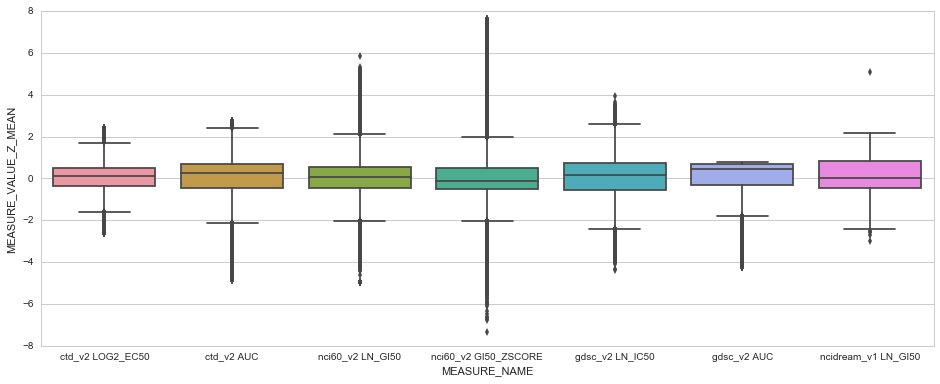

In [137]:
plt.figure(figsize=(16,6))
sns.boxplot(
    x='MEASURE_NAME', y='MEASURE_VALUE_Z_MEAN', 
    data=d_drug_summary\
        .assign(MEASURE_NAME=d_drug_summary['SOURCE']\
        .str.cat(d_drug_summary['MEASURE_UNIT'], sep=' '))
)

In [117]:
d_drug_summary['SOURCE_N'].value_counts()

1    1280560
2     254766
3     109021
4       6308
Name: SOURCE_N, dtype: int64

## Export

In [244]:
d_exp = d_drug_exp.copy()
d_exp['SOURCE_NAME'] = d_exp['SOURCE'].apply(src.get_pretty_name)
sql_export.export_sql_db(d_exp, 'drug_sensitivity_replicate_data', 'mgds', export_csv=True)

2016-12-09 13:08:08,847:INFO:mgds.data_aggregation.export_lib.sql_export: Successfully exported data to table "drug_sensitivity_replicate_data" at database path "sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db"


'sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db'

In [245]:
d_exp = d_drug_summary.copy()
d_exp['SOURCE_NAME'] = d_exp['SOURCE'].apply(src.get_pretty_name)
sql_export.export_sql_db(d_exp, 'drug_sensitivity_summary_data', 'mgds', export_csv=True)

2016-12-09 13:09:41,625:INFO:mgds.data_aggregation.export_lib.sql_export: Successfully exported data to table "drug_sensitivity_summary_data" at database path "sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db"


'sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db'

In [42]:
d_exp = d_rx.stack(level=[0,1]).rename('DRUG_NAME:SOURCE').reset_index()
d_exp['SOURCE_NAME'] = d_exp['SOURCE'].apply(src.get_pretty_name)
sql_export.export_sql_db(d_exp, 'drug_name_mappings', 'mgds', export_csv=True)
d_exp.info()

2016-12-08 13:27:40,618:INFO:mgds.data_aggregation.export_lib.sql_export: Successfully exported data to table "drug_name_mappings" at database path "sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14293 entries, 0 to 14292
Data columns (total 4 columns):
DRUG_NAME:MGDS      14293 non-null object
TAXONOMY            14293 non-null object
SOURCE              14293 non-null object
DRUG_NAME:SOURCE    14293 non-null object
dtypes: object(4)
memory usage: 446.7+ KB


# Analysis

In [311]:
dt = d_drug_summary.copy()
dt = dt.set_index(['DRUG_NAME:MGDS', 'CELL_LINE_ID:MGDS', 'MEASURE_UNIT', 'SOURCE'])['MEASURE_VALUE_Z_MEAN']
dt = dt.unstack().unstack()
c_measure = [
    (src.CTD_v2, 'LOG2_EC50'), (src.GDSC_v2, 'LN_IC50'), #(src.NCI60_v2, 'GI50_ZSCORE'),
    (src.CTD_v2, 'AUC'), (src.GDSC_v2, 'AUC'), (src.NCI60_v2, 'LN_GI50')
]
dt = dt[c_measure]
dt['N_VALUES'] = dt.notnull().sum(axis=1).astype(str)
dt = dt.set_index('N_VALUES', append=True)
dt.index = dt.index.swaplevel(i=-1, j=-3)

dt[('all', 'MEAN')] = dt[c_measure].mean(axis=1)
for c in c_measure:
    dt[(c[0], c[1]+':diff')] = dt[c] - dt[('all', 'MEAN')]
dt.columns = [':'.join(c) for c in dt.columns]
dt.head()

ctd_v2:LOG2_EC50  gdsc_v2:LN_IC50  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                                      
1        7860              010200                       NaN              NaN   
         A498              010200                       NaN              NaN   
         A549ATCC          010200                       NaN              NaN   
         ACHN              010200                       NaN              NaN   
         BT549             010200                       NaN              NaN   

                                           ctd_v2:AUC  gdsc_v2:AUC  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                            
1        7860              010200                 NaN          NaN   
         A498              010200                 NaN          NaN   
         A549ATCC          010200                 NaN          NaN   
         ACHN              010200                 NaN          NaN   
         BT549             010200                 NaN          NaN   

                                           nci60_v2:LN_GI50  all:MEAN  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                               
1        7860              010200                  0.943718  0.943718   
         A498              010200                  1.275635  1.275635   
         A549ATCC          010200                  1.193511  1.193511   
         ACHN              010200                  1.196933  1.196933   
         BT549             010200                  0.974515  0.974515   

                                           ctd_v2:LOG2_EC50:diff  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                          
1        7860              010200                            NaN   
         A498              010200                            NaN   
         A549ATCC          010200                            NaN   
         ACHN              010200                            NaN   
         BT549             010200                            NaN   

                                           gdsc_v2:LN_IC50:diff  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                         
1        7860              010200                           NaN   
         A498              010200                           NaN   
         A549ATCC          010200                           NaN   
         ACHN              010200                           NaN   
         BT549             010200                           NaN   

                                           ctd_v2:AUC:diff  gdsc_v2:AUC:diff  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                                      
1        7860              010200                      NaN               NaN   
         A498              010200                      NaN               NaN   
         A549ATCC          010200                      NaN               NaN   
         ACHN              010200                      NaN               NaN   
         BT549             010200                      NaN               NaN   

                                           nci60_v2:LN_GI50:diff  
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                         
1        7860              010200                            0.0  
         A498              010200                            0.0  
         A549ATCC          010200                            0.0  
         ACHN              010200                            0.0  
         BT549             010200                            0.0

In [312]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 786155 entries, (1, 7860, 010200) to (1, UO31, ZYGOSPORINA)
Data columns (total 11 columns):
ctd_v2:LOG2_EC50         387130 non-null float64
gdsc_v2:LN_IC50          205148 non-null float64
ctd_v2:AUC               387130 non-null float64
gdsc_v2:AUC              205148 non-null float64
nci60_v2:LN_GI50         232479 non-null float64
all:MEAN                 785130 non-null float64
ctd_v2:LOG2_EC50:diff    387130 non-null float64
gdsc_v2:LN_IC50:diff     205148 non-null float64
ctd_v2:AUC:diff          387130 non-null float64
gdsc_v2:AUC:diff         205148 non-null float64
nci60_v2:LN_GI50:diff    232479 non-null float64
dtypes: float64(11)
memory usage: 72.0+ MB


In [313]:
dt.loc[str(len(c_measure))].filter(regex='diff').iplot(kind='histogram', bins=100)

In [321]:
dt[dt.index.get_level_values('DRUG_NAME:MGDS') == 'NAVITOCLAX']\
    .filter(regex='^(?!.*diff)').sort_values('all:MEAN').iplot(mode='markers', size=3)

In [324]:
dt.loc[str(len(c_measure))].filter(regex='^(?!.*diff)').sort_values('all:MEAN').iplot(mode='markers', size=3)

In [325]:
dt2 = dt.loc[str(len(c_measure))].filter(regex='^(?!.*diff)').sort_values('all:MEAN')
y = dt2['all:MEAN']
y_std = dt2.filter(regex='^(?!.*:MEAN)').std(axis=1)
pd.DataFrame({
    'Average': y, 
    'Average + 1 STD': (y + y_std).rolling(center=True, window=5).mean(), 
    'Average - 1 STD': (y - y_std).rolling(center=True, window=5).mean()
}).iplot()

In [238]:
dt = d_drug_summary.copy()
def agg(v):
    assert len(v) == 1
    return v.iloc[0]
dt = dt.set_index(['DRUG_NAME:MGDS', 'CELL_LINE_ID:MGDS', 'MEASURE_UNIT', 'SOURCE'])['MEASURE_VALUE_Z_MEAN']
dt = dt.unstack().unstack().dropna(how='all', axis=1)
dt.columns = [':'.join(c) for c in dt]
dt.head()

ctd_v2:AUC  ctd_v2:LOG2_EC50  gdsc_v2:AUC  \
DRUG_NAME:MGDS CELL_LINE_ID:MGDS                                              
010200         7860                      NaN               NaN          NaN   
               A498                      NaN               NaN          NaN   
               A549ATCC                  NaN               NaN          NaN   
               ACHN                      NaN               NaN          NaN   
               BT549                     NaN               NaN          NaN   

                                  gdsc_v2:LN_IC50  nci60_v2:GI50_ZSCORE  \
DRUG_NAME:MGDS CELL_LINE_ID:MGDS                                          
010200         7860                           NaN                  1.85   
               A498                           NaN                 -0.99   
               A549ATCC                       NaN                 -0.32   
               ACHN                           NaN                 -0.32   
               BT549                          NaN                  1.60   

                                  nci60_v2:LN_GI50  ncidream_v1:LN_GI50  
DRUG_NAME:MGDS CELL_LINE_ID:MGDS                                         
010200         7860                       0.943718                  NaN  
               A498                       1.275635                  NaN  
               A549ATCC                   1.193511                  NaN  
               ACHN                       1.196933                  NaN  
               BT549                      0.974515                  NaN

In [242]:
dt.notnull().sum(axis=1).sort_values(ascending=False).head(10)

DRUG_NAME:MGDS  CELL_LINE_ID:MGDS
DOXORUBICIN     HS578T               7
                MCF7                 7
                T47D                 7
                MDAMB231             7
ETOPOSIDE       OVCAR4               6
NILOTINIB       SF268                6
TEMSIROLIMUS    NCIH226              6
ETOPOSIDE       OVCAR8               6
                OVCAR5               6
TEMSIROLIMUS    SKOV3                6
dtype: int64

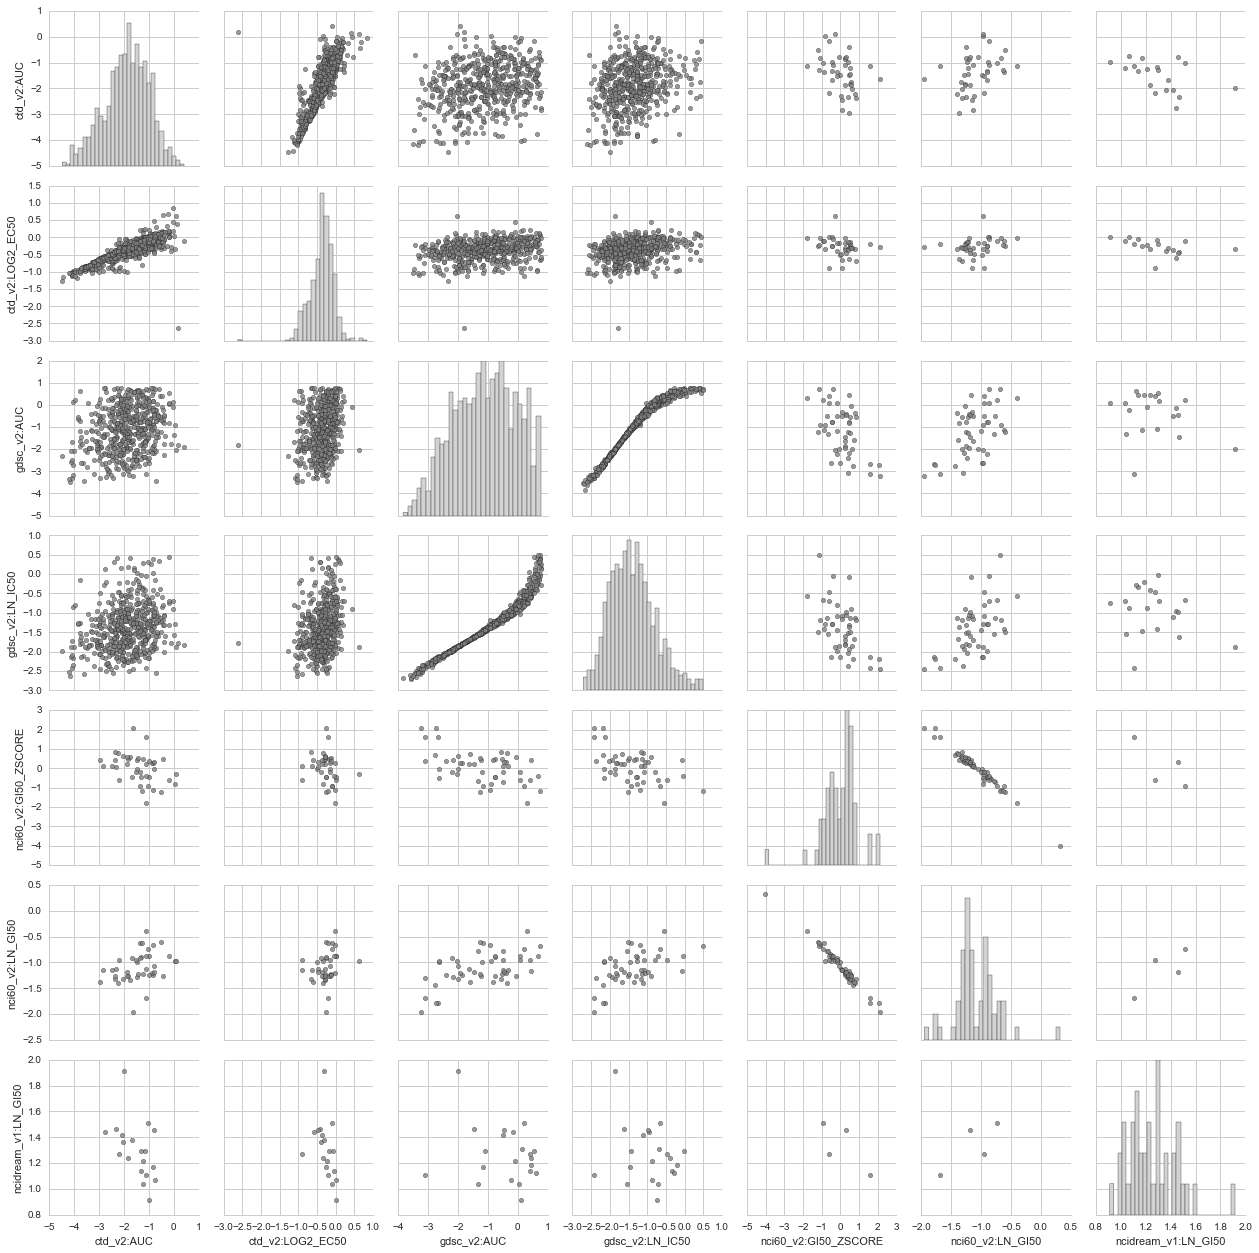

In [262]:
drug_name = 'DOXORUBICIN'

def plot_scatter(x, y, **kwargs):
    is_na = x.isnull() | y.isnull()
    return plt.scatter(x[~is_na], y[~is_na], alpha=.8, c='grey')

def plot_diag(x, **kwargs):
    return plt.hist(x.dropna(), bins=30, color='lightgrey')

g = sns.PairGrid(dt.loc[drug_name], diag_sharey=False)
g.map_offdiag(plot_scatter)
g.map_diag(plot_diag)